In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
#review what columns are in the data
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
#See what the data looks like so we can filter our queries
session.query(Measurement.date, Measurement.prcp).limit(5).all()

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None)]

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Locate the last date in the dataset
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [34]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [35]:
# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

last_year_prcp

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

# Exploratory Climate Analysis

In [52]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_prcp, columns =['date', 'precipitation',])

# 
last_year_df[last_year_df.precipitation != 'None']

# Sort the dataframe by date
last_year_df.sort_values('date', ascending = True)
last_year_df.set_index('date', inplace=True)
last_year_df.head()

# Use Pandas Plotting with Matplotlib to plot the data


C:\Users\jerem\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


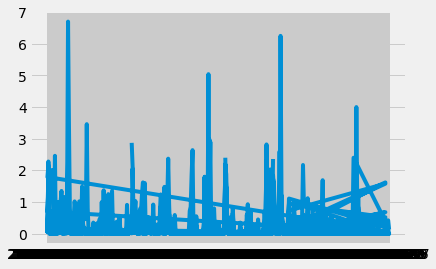

In [53]:
plt.plot(last_year_df)

![precipitation](Images/precipitation.png)

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
count_prcp = last_year_df.count()
mean_prcp = last_year_df.mean()
mean_prcp = last_year_df.std()
min_prcp = last_year_df.min()
q25_prcp = last_year_df.quantile(0.25)
q50_prcp = last_year_df.quantile(0.5)
q75_rcp = last_year_df.quantile(0.5)
max_prcp = last_year_df.max()

precipitation    2021
dtype: int64

In [64]:
#prcp_summary =  [{Count: count_prcp}, {Mean: mean_prcp}]
prcp_df = pd.DataFrame({"Count": count_prcp}, {"Mean": mean_prcp})
prcp_df

,Count
Mean,NaN


![describe](Images/describe.png)

In [68]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]

station_active = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

In [84]:
station_summary = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

station_summary

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [81]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_query = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).all()

station_query

[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC005192

In [ ]:
#DO PLOT HERE

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


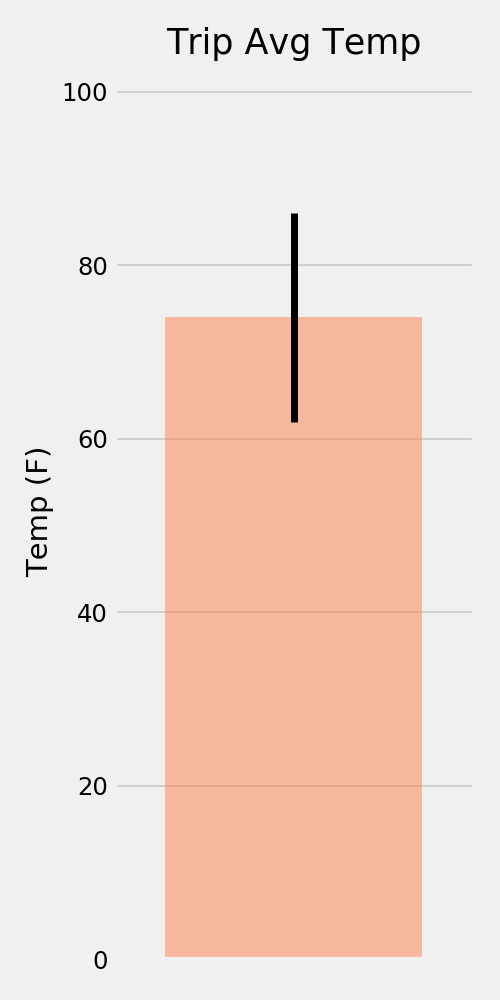

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
